In [2]:
# BEGIN USING PYPORTFOLIO OPT LIBRARY - Note I used all eleven sectors below

In [91]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import json
from pathlib import Path
import alpaca_trade_api as tradeapi
import requests
import os
import seaborn as sns
from dotenv import load_dotenv

from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import Plotting
from pypfopt import CLA
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage


%matplotlib inline

In [92]:
#ALPACA data retrieval 
load_dotenv()

alpaca_api_key = os.getenv("Api_key")
alpaca_secret_key = os.getenv("Secret_Key")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')


type(alpaca_api_key)

str

In [93]:
#Use alpha vantage to get historic quotes for all S&P sectors. This goes back 20 years.

# Can only do 5 calls a minute or you will get error. Might have to wait a minute after
#running this cell. 

xlb_df = api.alpha_vantage.historic_quotes('XLB', adjusted=True, output_format='pandas')
#xlb_df.head()

xlk_df = api.alpha_vantage.historic_quotes('XLK', adjusted=True, output_format='pandas')
# xlk_df.tail()

rwr_df = api.alpha_vantage.historic_quotes('RWR', adjusted=True, output_format='pandas')
#rwr_df.head()

xli_df = api.alpha_vantage.historic_quotes('XLI', adjusted=True, output_format='pandas')
#rwr_df.head()

xly_df = api.alpha_vantage.historic_quotes('XLY', adjusted=True, output_format='pandas')
#xly_df.head()





In [95]:
#Might have to wait a minute before running this cell

xlp_df = api.alpha_vantage.historic_quotes('XLP', adjusted=True, output_format='pandas')
#xlp_df.head()

xle_df = api.alpha_vantage.historic_quotes('XLE', adjusted=True, output_format='pandas')
#xle_df.head()

xlf_df = api.alpha_vantage.historic_quotes('XLF', adjusted=True, output_format='pandas')
#xlf_df.head()

xlu_df = api.alpha_vantage.historic_quotes('XLU', adjusted=True, output_format='pandas')
#xlu_df.head()

xlv_df = api.alpha_vantage.historic_quotes('XLV', adjusted=True, output_format='pandas')
#xlv_df.head()

In [96]:

#Might have to wait a minute before running this cell

iyt_df = api.alpha_vantage.historic_quotes('IYT', adjusted=True, output_format='pandas')
#iyt_df.head()

In [97]:
xlu_df.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
date,,,,,,,,
2020-05-01,56.59,56.630,55.5600,55.88,55.88,13458584.0,0.0,1.0
2020-04-30,58.19,58.280,56.7300,57.26,57.26,19366858.0,0.0,1.0
2020-04-29,60.11,60.140,58.3700,58.61,58.61,11782714.0,0.0,1.0
2020-04-28,59.76,60.400,58.8778,59.15,59.15,14321700.0,0.0,1.0
2020-04-27,58.66,59.355,58.6000,58.93,58.93,12739948.0,0.0,1.0


In [98]:
#DATA CLEANUP

#Select the one column we need,  "adjusted close", and drop the others

xlb_df = xlb_df['5. adjusted close']
xlb_df.head()

xlk_df = xlk_df['5. adjusted close']
xlk_df.head()

rwr_df = rwr_df['5. adjusted close']
rwr_df.head()

xli_df = xli_df['5. adjusted close']
xli_df.head()

xly_df = xly_df['5. adjusted close']
xly_df.head()

xlp_df = xlp_df['5. adjusted close']
xlp_df.head()

xle_df = xle_df['5. adjusted close']
xle_df.head()

xlf_df = xlf_df['5. adjusted close']
xlf_df.head()

xlu_df = xlu_df['5. adjusted close']
xlu_df.head()

xlv_df = xlv_df['5. adjusted close']
xlv_df.head()

iyt_df = iyt_df['5. adjusted close']
iyt_df.head()


#Use concat to put the data in one dataframe
concat_df = pd.concat([xlb_df, xlk_df, rwr_df, xli_df, xly_df, xlp_df, xle_df, xlf_df, xlu_df, xlv_df, iyt_df], 
                      axis = "columns", join = "inner")
concat_df.head()



,5. adjusted close,5. adjusted close,5. adjusted close,5. adjusted close,5. adjusted close,5. adjusted close,5. adjusted close,5. adjusted close,5. adjusted close,5. adjusted close,5. adjusted close
date,,,,,,,,,,,
2020-05-01,50.79,88.90,75.11,62.27,112.24,57.62,35.85,22.06,55.88,97.83,144.775
2020-04-30,51.88,91.41,77.87,64.21,116.60,58.26,38.00,22.79,57.26,99.73,149.920
2020-04-29,53.47,91.82,79.10,65.51,117.33,58.96,38.86,23.38,58.61,100.19,154.400
2020-04-28,52.14,88.20,77.38,64.28,114.80,59.21,36.18,22.72,59.15,99.53,150.270
2020-04-27,51.19,89.39,76.08,63.10,114.35,58.88,35.37,22.48,58.93,101.58,148.900


In [99]:
#Change column names to avoid confusion
columns = ['XLB', 'XLK', 'RWR', 'XLI', 'XLY', 'XLP', 'XLE', 'XLF', 'XLU', 'XLV', 'IYT']
concat_df.columns = columns
concat_df.head()

,XLB,XLK,RWR,XLI,XLY,XLP,XLE,XLF,XLU,XLV,IYT
date,,,,,,,,,,,
2020-05-01,50.79,88.90,75.11,62.27,112.24,57.62,35.85,22.06,55.88,97.83,144.775
2020-04-30,51.88,91.41,77.87,64.21,116.60,58.26,38.00,22.79,57.26,99.73,149.920
2020-04-29,53.47,91.82,79.10,65.51,117.33,58.96,38.86,23.38,58.61,100.19,154.400
2020-04-28,52.14,88.20,77.38,64.28,114.80,59.21,36.18,22.72,59.15,99.53,150.270
2020-04-27,51.19,89.39,76.08,63.10,114.35,58.88,35.37,22.48,58.93,101.58,148.900


In [100]:
#Sort earliest to latest 

concat_df.sort_index(inplace=True, ascending=True)
concat_df.head()


,XLB,XLK,RWR,XLI,XLY,XLP,XLE,XLF,XLU,XLV,IYT
date,,,,,,,,,,,
2003-10-10,15.6663,15.2225,24.9652,17.2546,23.4176,13.9255,16.9139,15.2858,12.1628,21.2388,42.1221
2003-10-13,15.8310,15.2692,25.0908,17.3261,23.6569,13.9785,16.9818,15.5271,12.2403,21.2993,42.7774
2003-10-14,15.9340,15.2303,25.1083,17.4118,23.7845,14.0515,16.9139,15.6190,12.2735,21.3296,43.0097
2003-10-15,15.9203,15.3238,25.0088,17.4404,23.6888,14.0316,16.6694,15.5788,12.1186,21.2842,42.6696
2003-10-16,15.9752,15.3783,25.1222,17.4476,23.7925,14.0515,16.8460,15.5960,12.1739,21.3977,42.8023


In [101]:
#check for nulls

concat_df.isnull().sum()

# Drop nulls
concat_df.dropna(inplace=True)

#count nulls again
concat_df.isnull().sum()

XLB    0
XLK    0
RWR    0
XLI    0
XLY    0
XLP    0
XLE    0
XLF    0
XLU    0
XLV    0
IYT    0
dtype: int64

In [102]:
# drop duplicates
concat_df.drop_duplicates(inplace=True)

In [103]:
#check counts
concat_df.count()

XLB    4168
XLK    4168
RWR    4168
XLI    4168
XLY    4168
XLP    4168
XLE    4168
XLF    4168
XLU    4168
XLV    4168
IYT    4168
dtype: int64

In [104]:
# Read in price data
#df = pd.read_csv("tests/resources/stock_prices.csv", parse_dates=True, index_col="date")

opt_df = concat_df



In [105]:
#Calculate covariance matrix, use ledoit wolf shrinkage which reduces extreme values

S = risk_models.CovarianceShrinkage(opt_df).ledoit_wolf()
S

,XLB,XLK,RWR,XLI,XLY,XLP,XLE,XLF,XLU,XLV,IYT
XLB,0.056572,0.038095,0.048402,0.042867,0.039105,0.021882,0.053688,0.052857,0.025479,0.027528,0.045318
XLK,0.038095,0.044803,0.041832,0.037087,0.037208,0.021779,0.040761,0.046921,0.023457,0.027369,0.038435
RWR,0.048402,0.041832,0.098352,0.046866,0.048370,0.026896,0.048981,0.075762,0.033570,0.030187,0.050705
XLI,0.042867,0.037087,0.046866,0.044880,0.038489,0.021977,0.045040,0.051963,0.024038,0.027389,0.045299
XLY,0.039105,0.037208,0.048370,0.038489,0.044229,0.021952,0.039908,0.051179,0.022742,0.026665,0.041929
XLP,0.021882,0.021779,0.026896,0.021977,0.021952,0.020938,0.023020,0.027436,0.019074,0.018640,0.022495
XLE,0.053688,0.040761,0.048981,0.045040,0.039908,0.023020,0.085652,0.055494,0.031656,0.030388,0.045193
XLF,0.052857,0.046921,0.075762,0.051963,0.051179,0.027436,0.055494,0.093189,0.029895,0.034539,0.055643
XLU,0.025479,0.023457,0.033570,0.024038,0.022742,0.019074,0.031656,0.029895,0.035287,0.020144,0.023860
XLV,0.027528,0.027369,0.030187,0.027389,0.026665,0.018640,0.030388,0.034539,0.020144,0.030580,0.027770


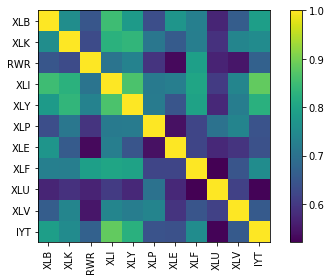

In [106]:
Plotting.plot_covariance(S);

In [107]:

# Calculate expected returns 
mu = expected_returns.mean_historical_return(opt_df)
#mu = expected_returns.capm_return(opt_df)

S = risk_models.CovarianceShrinkage(opt_df).ledoit_wolf()

# Optimize for maximum Sharpe ratio. The result is also referred to as the tangency portfolio, 
# as it is the portfolio for which the capital market line is tangent to the efficient frontier.

ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()

#If you want minimum volatility portfolio use: 
#raw_weights =ef.min_volatility()

#round weights
cleaned_weights = ef.clean_weights()

ef.save_weights_to_file("weights.csv")  

print(cleaned_weights)

ef.portfolio_performance(verbose=True)

{'XLB': 0.0, 'XLK': 0.25895, 'RWR': 0.0, 'XLI': 0.0, 'XLY': 0.0, 'XLP': 0.34463, 'XLE': 0.0, 'XLF': 0.0, 'XLU': 0.2185, 'XLV': 0.17792, 'IYT': 0.0}
Expected annual return: 11.0%
Annual volatility: 15.5%
Sharpe Ratio: 0.58


(0.10973282770813425, 0.1546997150579963, 0.5800452035383115)

In [108]:
#Now convert weights into shares to buy given total portfolio value, say $20,000

from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(opt_df)
da = DiscreteAllocation(raw_weights, latest_prices, total_portfolio_value=20000)
allocation, leftover = da.lp_portfolio()
print(f"Discrete allocation performed with ${leftover:.2f} leftover")
print(allocation)


Discrete allocation performed with $8.67 leftover
{'XLK': 58.0, 'XLP': 119.0, 'XLU': 78.0, 'XLV': 37.0}


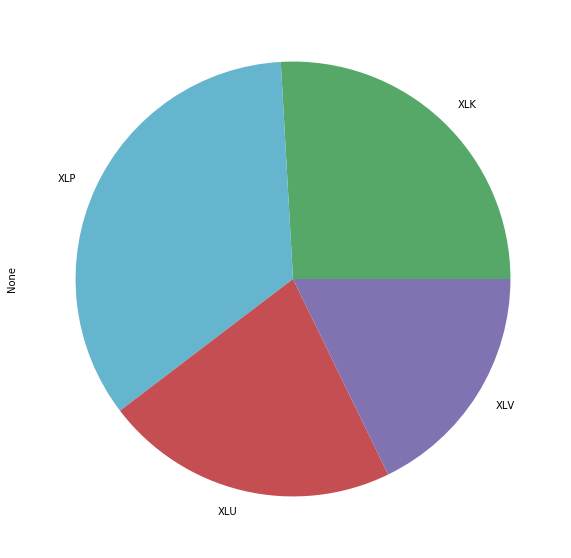

In [109]:
#Cam is not going to like this!

pd.Series(cleaned_weights).plot.pie(figsize=(10,10))


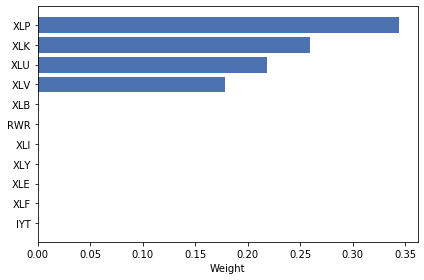

In [110]:
Plotting.plot_weights(cleaned_weights)

In [111]:
#MONTE CARLO SIMULATION OF OPTIMIZED PORTFOLIO

In [112]:
daily_returns = concat_df.pct_change()
daily_returns.dropna(inplace=True)
daily_returns.head()

,XLB,XLK,RWR,XLI,XLY,XLP,XLE,XLF,XLU,XLV,IYT
date,,,,,,,,,,,
2003-10-13,0.010513,0.003068,0.005031,0.004144,0.010219,0.003806,0.004014,0.015786,0.006372,0.002849,0.015557
2003-10-14,0.006506,-0.002548,0.000697,0.004946,0.005394,0.005222,-0.003998,0.005919,0.002712,0.001423,0.005430
2003-10-15,-0.000860,0.006139,-0.003963,0.001643,-0.004024,-0.001416,-0.014456,-0.002574,-0.012621,-0.002128,-0.007908
2003-10-16,0.003448,0.003557,0.004534,0.000413,0.004378,0.001418,0.010594,0.001104,0.004563,0.005333,0.003110
2003-10-17,-0.009452,-0.016211,-0.007846,-0.006964,-0.014080,-0.006135,-0.006856,-0.008836,-0.006366,-0.011319,-0.004458


In [113]:
#Calculate the mean of daily returns for each sector

avg_daily_return_xlb = daily_returns.mean()['XLB']
avg_daily_return_xlk = daily_returns.mean()['XLK']
avg_daily_return_rwr = daily_returns.mean()['RWR']
avg_daily_return_xli = daily_returns.mean()['XLI']
avg_daily_return_xly = daily_returns.mean()['XLY']
avg_daily_return_xlp = daily_returns.mean()['XLP']
avg_daily_return_xle = daily_returns.mean()['XLE']
avg_daily_return_xlf = daily_returns.mean()['XLF']
avg_daily_return_xlu = daily_returns.mean()['XLU']
avg_daily_return_xlv = daily_returns.mean()['XLV']
avg_daily_return_iyt = daily_returns.mean()['IYT']


In [114]:
#Calculate the standard deviation of returns for each sector

std_dev_daily_return_xlb = daily_returns.std()['XLB']
std_dev_daily_return_xlk = daily_returns.std()['XLK']
std_dev_daily_return_rwr = daily_returns.std()['RWR']
std_dev_daily_return_xli = daily_returns.std()['XLI']
std_dev_daily_return_xly = daily_returns.std()['XLY']
std_dev_daily_return_xlp = daily_returns.std()['XLP']
std_dev_daily_return_xle = daily_returns.std()['XLE']
std_dev_daily_return_xlf = daily_returns.std()['XLF']
std_dev_daily_return_xlu = daily_returns.std()['XLU']
std_dev_daily_return_xlv = daily_returns.std()['XLV']
std_dev_daily_return_iyt = daily_returns.std()['IYT']


In [115]:
#RUN MONTE CARLO SIMULATION OF THE OPTIMIZED PORTFOLIO

# Set number of simulations and trading days
num_simulations = 1000
num_trading_days = 30

# Set last closing prices

xlb_last_price = concat_df['XLB'][-1]
xlk_last_price = concat_df['XLK'][-1]
rwr_last_price = concat_df['RWR'][-1]
xli_last_price = concat_df['XLI'][-1]
xly_last_price = concat_df['XLY'][-1]
xlp_last_price = concat_df['XLP'][-1]
xle_last_price = concat_df['XLE'][-1]
xlf_last_price = concat_df['XLF'][-1]
xlu_last_price = concat_df['XLU'][-1]
xlv_last_price = concat_df['XLV'][-1]
iyt_last_price = concat_df['IYT'][-1]


# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

# Run the simulation of projecting stock prices for the next 30 days, `1000` times
for n in range(num_simulations):

    # Initialize the simulated prices list with the last closing price of the sector etfs
    simulated_xlb_prices = [xlb_last_price]
    simulated_xlk_prices = [xlk_last_price]
    simulated_rwr_prices = [rwr_last_price]
    simulated_xli_prices = [xli_last_price]  
    simulated_xly_prices = [xly_last_price]
    simulated_xlp_prices = [xlp_last_price]
    simulated_xle_prices = [xle_last_price]
    simulated_xlf_prices = [xlf_last_price]
    simulated_xlu_prices = [xlu_last_price]  
    simulated_xlv_prices = [xlv_last_price]
    simulated_iyt_prices = [iyt_last_price]
    
    
    # Simulate the returns for 30 days
    for i in range(num_trading_days):
        
        # Calculate the simulated price using the last price within the list
        simulated_xlb_price = simulated_xlb_prices[-1] * (1 + np.random.normal(avg_daily_return_xlb, std_dev_daily_return_xlb))
        simulated_xlk_price = simulated_xlk_prices[-1] * (1 + np.random.normal(avg_daily_return_xlk, std_dev_daily_return_xlk))
        simulated_rwr_price = simulated_rwr_prices[-1] * (1 + np.random.normal(avg_daily_return_rwr, std_dev_daily_return_rwr))
        simulated_xli_price = simulated_xli_prices[-1] * (1 + np.random.normal(avg_daily_return_xli, std_dev_daily_return_xli))
        simulated_xly_price = simulated_xly_prices[-1] * (1 + np.random.normal(avg_daily_return_xly, std_dev_daily_return_xly))
        simulated_xlp_price = simulated_xlp_prices[-1] * (1 + np.random.normal(avg_daily_return_xlp, std_dev_daily_return_xlp))
        simulated_xle_price = simulated_xle_prices[-1] * (1 + np.random.normal(avg_daily_return_xle, std_dev_daily_return_xle))
        simulated_xlf_price = simulated_xlf_prices[-1] * (1 + np.random.normal(avg_daily_return_xlf, std_dev_daily_return_xlf))
        simulated_xlu_price = simulated_xlu_prices[-1] * (1 + np.random.normal(avg_daily_return_xlu, std_dev_daily_return_xlu))
        simulated_xlv_price = simulated_xlv_prices[-1] * (1 + np.random.normal(avg_daily_return_xlv, std_dev_daily_return_xlv))
        simulated_iyt_price = simulated_iyt_prices[-1] * (1 + np.random.normal(avg_daily_return_iyt, std_dev_daily_return_iyt))
        
        
        # Append the simulated price to the list
        simulated_xlb_prices.append(simulated_xlb_price)
        simulated_xlk_prices.append(simulated_xlk_price)
        simulated_rwr_prices.append(simulated_rwr_price)
        simulated_xli_prices.append(simulated_xli_price)
        simulated_xly_prices.append(simulated_xly_price)
        simulated_xlp_prices.append(simulated_xlp_price)
        simulated_xle_prices.append(simulated_xle_price)
        simulated_xlf_prices.append(simulated_xlf_price)
        simulated_xlu_prices.append(simulated_xlu_price)
        simulated_xlv_prices.append(simulated_xlv_price)
        simulated_iyt_prices.append(simulated_iyt_price)
 
            
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["XLB"] = pd.Series(simulated_xlb_prices)
    simulated_price_df["XLK"] = pd.Series(simulated_xlk_prices)
    simulated_price_df["RWR"] = pd.Series(simulated_xlb_prices)
    simulated_price_df["XLI"] = pd.Series(simulated_xlk_prices)
    simulated_price_df["XLY"] = pd.Series(simulated_xlb_prices)
    simulated_price_df["XLP"] = pd.Series(simulated_xlk_prices)
    simulated_price_df["XLE"] = pd.Series(simulated_xlb_prices)
    simulated_price_df["XLF"] = pd.Series(simulated_xlk_prices)
    simulated_price_df["XLU"] = pd.Series(simulated_xlb_prices)
    simulated_price_df["XLV"] = pd.Series(simulated_xlk_prices)
    simulated_price_df["IYT"] = pd.Series(simulated_xlb_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the optimized portfolio weights (XLB,XLK,RWR,XLI,XLY,XLP,XLE,XLF,XLU,XLV,IYT)
    weights = [0, 0.26569,0,0,0,.32729,0,0,.22731,.17971,0]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.head()


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.999689,1.005896,1.000653,1.008823,0.999394,0.998617,0.988304,1.006015,1.000753,1.013233,...,0.996507,1.005889,1.006071,1.004881,0.975961,0.995047,1.000558,0.996110,1.012287,0.973154
2,0.978271,1.010498,1.011359,0.987968,1.010417,1.010691,0.956909,0.985296,0.988180,1.018847,...,1.001862,1.035610,0.999407,0.986504,0.987173,1.007489,0.998924,0.998978,1.007544,0.963360
3,0.970671,1.006632,1.002585,0.986120,0.999426,0.996169,0.961474,1.007173,0.976258,1.029758,...,0.998621,1.041166,1.023691,0.993561,0.986322,1.003816,1.013564,1.012905,1.029964,0.971168
4,0.956270,1.008375,0.991023,0.977078,1.000376,0.984744,0.954986,1.009198,0.968917,1.032977,...,0.985744,1.040638,1.018139,0.985913,0.988820,0.990920,1.003652,1.022289,1.017498,0.983091


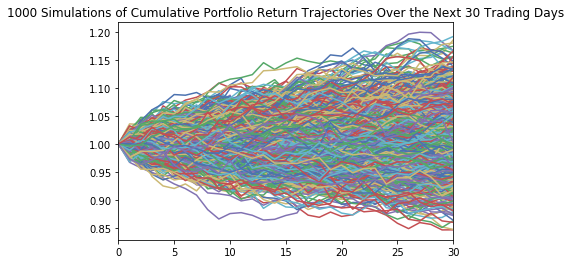

In [116]:
# Plot `1000` simulations of the potential trajectories of the portfolio based on 30 trading days
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 30 Trading Days"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [117]:
# Select the last row for prices (prices of each simulation on the 30th trading day)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    0.962270
1    1.018466
2    1.047009
3    0.965918
4    1.053122
Name: 30, dtype: float64

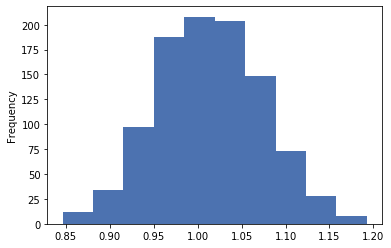

In [120]:
#Plot a frequency distribution of simulated ending prices
ending_cumulative_returns.plot(kind='hist', bins=10)

In [121]:
#Calculate probability distribution
ending_cumulative_returns.value_counts(bins=10) / len(ending_cumulative_returns)


(0.985, 1.019]    0.208
(1.019, 1.054]    0.204
(0.95, 0.985]     0.188
(1.054, 1.089]    0.148
(0.916, 0.95]     0.097
(1.089, 1.123]    0.073
(0.881, 0.916]    0.034
(1.123, 1.158]    0.028
(0.845, 0.881]    0.012
(1.158, 1.193]    0.008
Name: 30, dtype: float64

In [122]:
# Use the `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = ending_cumulative_returns.quantile(q=[0.025, 0.975])
confidence_interval

0.025    0.901393
0.975    1.134411
Name: 30, dtype: float64

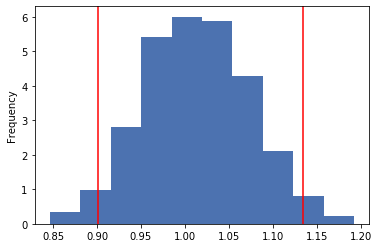

In [123]:
# Use the `plot` function to create a probability distribution histogram of simulated ending returns
# with markings for a 95% confidence interval
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

In [124]:
# Set initial investment
initial_investment = 10000

# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
investment_pnl_lower_bound = (initial_investment * confidence_interval.iloc[0])
investment_pnl_upper_bound = (initial_investment * confidence_interval.iloc[1])
                                                    
# Print the results
print(f"There is a 95% chance that an initial investment of $10,000 in the portfolio"
      f" over the next 30 trading days will end within in the range of"
      f" ${investment_pnl_lower_bound} and ${investment_pnl_upper_bound}")

There is a 95% chance that an initial investment of $10,000 in the portfolio over the next 30 trading days will end within in the range of $9013.92612182507 and $11344.110251924481


In [126]:
#Add optimized portfolio returns to daily returns dataframe

daily_returns['optimized']= (daily_returns['XLK']*.258599)+(daily_returns['XLP']*.34463)
+(daily_returns['XLU']*.2185)+(daily_returns['XLV']*.17792)
daily_returns.head()

,XLB,XLK,RWR,XLI,XLY,XLP,XLE,XLF,XLU,XLV,IYT,optimized
date,,,,,,,,,,,,
2003-10-13,0.010513,0.003068,0.005031,0.004144,0.010219,0.003806,0.004014,0.015786,0.006372,0.002849,0.015557,0.002105
2003-10-14,0.006506,-0.002548,0.000697,0.004946,0.005394,0.005222,-0.003998,0.005919,0.002712,0.001423,0.005430,0.001141
2003-10-15,-0.000860,0.006139,-0.003963,0.001643,-0.004024,-0.001416,-0.014456,-0.002574,-0.012621,-0.002128,-0.007908,0.001099
2003-10-16,0.003448,0.003557,0.004534,0.000413,0.004378,0.001418,0.010594,0.001104,0.004563,0.005333,0.003110,0.001408
2003-10-17,-0.009452,-0.016211,-0.007846,-0.006964,-0.014080,-0.006135,-0.006856,-0.008836,-0.006366,-0.011319,-0.004458,-0.006306


In [127]:
#Add equal weighted portfolio returns to daily returns dataframe

daily_returns['equal']= (daily_returns['XLB']*.090909)+(daily_returns['XLK']*.090909)
+(daily_returns['RWR']*.090909)+(daily_returns['XLI']*.090909)+(daily_returns['XLY']*.090909)+(daily_returns['XLP']*.090909)
+(daily_returns['XLE']*.090909)+(daily_returns['XLF']*.090909)+(daily_returns['XLU']*.090909)+(daily_returns['XLV']*.090909)
+(daily_returns['IYT']*.090909)



daily_returns.head()

,XLB,XLK,RWR,XLI,XLY,XLP,XLE,XLF,XLU,XLV,IYT,optimized,equal
date,,,,,,,,,,,,,
2003-10-13,0.010513,0.003068,0.005031,0.004144,0.010219,0.003806,0.004014,0.015786,0.006372,0.002849,0.015557,0.002105,0.001235
2003-10-14,0.006506,-0.002548,0.000697,0.004946,0.005394,0.005222,-0.003998,0.005919,0.002712,0.001423,0.005430,0.001141,0.000360
2003-10-15,-0.000860,0.006139,-0.003963,0.001643,-0.004024,-0.001416,-0.014456,-0.002574,-0.012621,-0.002128,-0.007908,0.001099,0.000480
2003-10-16,0.003448,0.003557,0.004534,0.000413,0.004378,0.001418,0.010594,0.001104,0.004563,0.005333,0.003110,0.001408,0.000637
2003-10-17,-0.009452,-0.016211,-0.007846,-0.006964,-0.014080,-0.006135,-0.006856,-0.008836,-0.006366,-0.011319,-0.004458,-0.006306,-0.002333


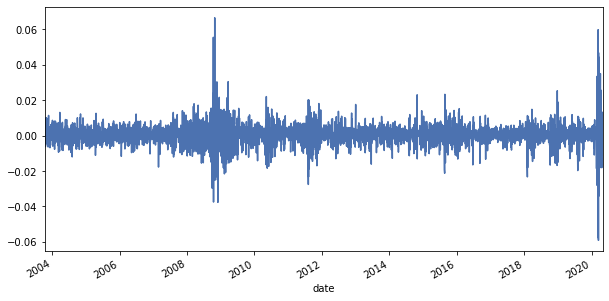

In [128]:
#plot daily returns of optimized portfolio

daily_returns['optimized'].plot(figsize=(10,5))

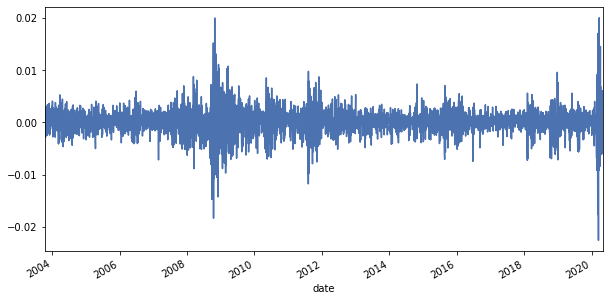

In [129]:
#plot daily returns of equally weighted portfolio

daily_returns['equal'].plot(figsize=(10,5))

In [130]:
# Calculate the cumulative returns using the 'cumprod()' function
cumulative_returns_optimized = (1 + daily_returns['optimized']).cumprod()
cumulative_returns_equal = (1 + daily_returns['equal']).cumprod()

cumulative_returns_optimized.head()

date
2003-10-13    1.002105
2003-10-14    1.003248
2003-10-15    1.004351
2003-10-16    1.005766
2003-10-17    0.999423
Name: optimized, dtype: float64

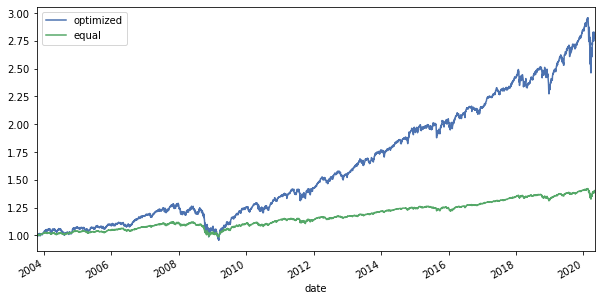

In [131]:
cumulative_returns_optimized.plot(figsize=(10,5),legend = True)
cumulative_returns_equal.plot(figsize=(10,5),legend = True)